Problem Statement
Classifying sleep stage using EEG and EOG data

Data Source:- Ask Palak<br>
Data format : 

Reading the data

In [1]:
from pandas import read_csv,unique

In [25]:
raw_data=read_csv('../sleep-stage-classification/dataset/SN001_sleepscoring.txt')
raw_data.head()


,Date,Time,Recording onset,Duration,Annotation,Linked channel
0,01.01.01,23.59.30,0.00,30,Sleep stage W,
1,02.01.01,00.00.00,30.00,30,Sleep stage W,
2,02.01.01,00.00.03.430,33.43,0,Lights off,EEG F4-A1
3,02.01.01,00.00.30,60.00,30,Sleep stage W,
4,02.01.01,00.01.00,90.00,30,Sleep stage W,


In [26]:
raw_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Recording onset,856.0,12795.072582,7417.375736,0.0,6382.5,12795.0,19207.5,25618.7
Duration,856.0,29.929907,1.449256,0.0,30.0,30.0,30.0,30.0


Exploratory data analysis

In [27]:
#check for count of unique values in different columns 
col_names_rd = raw_data.columns
for col in col_names_rd:
    print(col," ",len(unique(raw_data[col])))

Date   2
Time   856
Recording onset   856
Duration   2
Annotation   7
Linked channel   3


In [28]:
# take a look at columns with low count of unique values
for col in col_names_rd:
    if(len(unique(raw_data[col]))<raw_data.shape[0]/2):
        print(col,"\n",raw_data[col].value_counts())

Date 
 02.01.01    855
01.01.01      1
Name: Date, dtype: int64
Duration 
 30    854
0       2
Name: Duration, dtype: int64
Annotation 
  Sleep stage N2    430
 Sleep stage W     151
 Sleep stage R     141
 Sleep stage N1    109
 Sleep stage N3     23
 Lights off          1
 Lights on           1
Name: Annotation, dtype: int64
Linked channel 
                854
 EEG F4-A1       1
 EEG Fpz-Cz      1
Name: Linked channel, dtype: int64


There are only 3 channels and most of the records have missing Linked channels
Two records have Lights data instead of Sleep stage these two records can be dropped too.
Two records with duration value 0 can be dropped.

<h3> Plotting various plots for data visualization

In [62]:
from matplotlib.pyplot import plot,xticks,show,xlabel,ylabel,title,figure

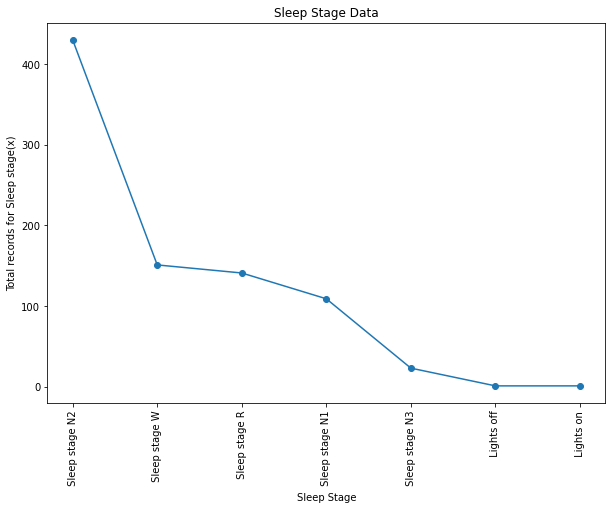

In [74]:
plot_data=raw_data['Annotation'].value_counts()
figure(figsize=(10,7))
title("Sleep Stage Data")
xlabel('Sleep Stage')
ylabel('Total records for Sleep stage(x)')
plot(plot_data,'-o')
xticks(rotation=90)
show()

Convert the .edf data file into csv for smooth processing of data

In [6]:
from mne.io import read_raw_edf
from numpy import savetxt

Read the edf file, extract channel names

In [2]:
edf_file=read_raw_edf('../sleep-stage-classification/dataset/SN001.edf')

Extracting EDF parameters from e:\github\sleep-stage-classification\dataset\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [8]:
headers=','.join(edf_file.ch_names) # channel names
savetxt('../sleep-stage-classification/dataset/SN001.csv',edf_file.get_data().T,delimiter=',',header=headers)